In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import keras
import PIL

import keras.backend as K
from tensorflow.python.framework import ops

from scipy import ndimage

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load model
# Can be downloaded here: https://drive.google.com/file/d/1gq7QFVzBxzw-jGiKB1siJzvxg5mGuUH6/view
# Original CNTK model was trained by kanotype: http://twitter.com/kanotype
classif_model = keras.models.load_model("kanotype_deepdanbooru_resnet-custom-v2.hdf5")

# Load tags
with open("kanotype_deepdanbooru_resnet-custom-v2_tags.txt", 'r') as tags_stream:
    tags = np.array([tag for tag in (tag.strip() for tag in tags_stream) if tag])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# Load image
# it's everyone's favourite idol, hibiki ganaha: https://gelbooru.com/index.php?page=post&s=view&id=4767465
in_path = "hibiki.jpg" 

image = np.array(PIL.Image.open(in_path).convert('RGB').resize((299, 299), resample = PIL.Image.LANCZOS)) / 255.0
image_arr = np.array([image])

# Decode
results = classif_model.predict(image_arr).reshape(tags.shape[0])

In [ ]:
#classif_model.summary()

In [4]:
# For grad-cam: Create gradient class selector variable
class_selector_shape = (len(tags), 1)
class_selector_var = tf.get_variable("gradcam_class_selector", class_selector_shape)

In [7]:
out_layer = classif_model.layers[-1].output
gradcam_loss_func = tf.multiply(out_layer, class_selector_var)
gradcam_loss = tf.reduce_sum(gradcam_loss_func)
grads_vars = tf.gradients(gradcam_loss, [classif_model.layers[0].input])

In [8]:
sess = K.get_session()

In [9]:
# Threshold and get tags
threshold = 0.1
result_tags = {}
for i in range(len(tags)):
    if results[i] > threshold:
        result_tags[tags[i]] = results[i]

# Print in order        
sorted_tags = reversed(sorted(result_tags.keys(), key = lambda x: result_tags[x]))
for tag in sorted_tags:
    print('{0: <32} {1:04f}'.format(tag, result_tags[tag]))

ganaha_hibiki                    0.998756
1girl                            0.995790
jewelry                          0.993498
animal                           0.984292
rating:safe                      0.983508
ponytail                         0.959574
breasts                          0.956939
long_hair                        0.956815
earrings                         0.941768
black_hair                       0.919423
open_mouth                       0.901638
score:very_good                  0.897160
hamster                          0.878725
blue_eyes                        0.854218
fang                             0.848023
barefoot                         0.833461
swimsuit                         0.829082
smile                            0.815426
cleavage                         0.786772
dog                              0.782905
bikini                           0.772529
solo                             0.726675
bracelet                         0.718262
looking_at_viewer                0

In [10]:
def gradcam(classes):
    """
    Get gradient at inputs that maximizes the given class(es)
    """
    if not isinstance(classes, list):
        classes = [classes]
        
    class_nhot = np.zeros(len(tags))
    for gradcam_class in classes:
        class_idx = list(tags).index(gradcam_class)
        class_nhot[class_idx] = 1.0
    class_nhot = class_nhot.reshape(class_nhot.shape[0], 1)

    return sess.run([
        class_selector_var.assign(class_nhot), 
        grads_vars[0]
    ], feed_dict = {classif_model.layers[0].input: image_arr})[1][0]
    

In [11]:
# Find gradients for all result tags
# This is very slow. I think it should be possible to have tensorflow compute alls these gradients at once, maybe.
# (patches welcome)
gradcam_maps = {}
for idx, tag in enumerate(result_tags.keys()):
    print("Processing tags, {} of {}".format(idx + 1, len(result_tags)))
    gradcam_maps[tag] = gradcam(tag)

Processing tags, 1 of 58
Processing tags, 2 of 58
Processing tags, 3 of 58
Processing tags, 4 of 58
Processing tags, 5 of 58
Processing tags, 6 of 58
Processing tags, 7 of 58
Processing tags, 8 of 58
Processing tags, 9 of 58
Processing tags, 10 of 58
Processing tags, 11 of 58
Processing tags, 12 of 58
Processing tags, 13 of 58
Processing tags, 14 of 58
Processing tags, 15 of 58
Processing tags, 16 of 58
Processing tags, 17 of 58
Processing tags, 18 of 58
Processing tags, 19 of 58
Processing tags, 20 of 58
Processing tags, 21 of 58
Processing tags, 22 of 58
Processing tags, 23 of 58
Processing tags, 24 of 58
Processing tags, 25 of 58
Processing tags, 26 of 58
Processing tags, 27 of 58
Processing tags, 28 of 58
Processing tags, 29 of 58
Processing tags, 30 of 58
Processing tags, 31 of 58
Processing tags, 32 of 58
Processing tags, 33 of 58
Processing tags, 34 of 58
Processing tags, 35 of 58
Processing tags, 36 of 58
Processing tags, 37 of 58
Processing tags, 38 of 58
Processing tags, 39 o

In [18]:
def norm_clip_grads(grads):
    """
    Normalize gradcam gradients by clipping them to between the 1st and 
    the 99th percentile, taking the absolute value and then mapping that 
    range to 0 -> 1
    
    TODO: maybe it should allow negative actually
    """
    upper_quantile = np.quantile(grads, 0.99)
    lower_quantile = np.quantile(grads, 0.01)
    clipped_grads = np.abs(np.clip(grads, lower_quantile, upper_quantile))
    return clipped_grads / np.max(clipped_grads)

def postprocess_grads(grads, filter_width = 10):
    """
    Normalize gradients, take the mean and apply
    a median filter
    """
    gradcam_map = np.mean(norm_clip_grads(grads), axis = -1)
    return ndimage.median_filter(gradcam_map, filter_width)
 
def threshold_map(gradcam_map, all_maps, filter_width = 10):
    """
    Refine gradcam map by applying a threshold mask that zeroes out
    areas where the map is not bigger than the average of all maps
    (i.e. remove areas that are only "generally interesting" instead
    of interesting for this tag specifically)
    """
    threshold_mask = gradcam_map > np.mean(all_maps, axis = 0)
    return ndimage.median_filter(threshold_mask, filter_width) * gradcam_map

def mask_for_tags(tags, gradcam_maps, clip_value = 0.3, regu_value = 0.0, median_filter_width = 10):
    """
    Given tag(s) and a set of (normalized) gradcam maps, generate a mask of pixels
    that contribute to the image being assigned those tags
    
    Maps are combined multiplicatively
    """
    if not isinstance(tags, list):
        tags = [tags]
    
    tags_map = np.ones(gradcam_maps_processed[tags[0]].shape)
    for tag in tags:
        tag_map = threshold_map(gradcam_maps_processed[tag], list(gradcam_maps_processed.values()))
        tag_map = ndimage.median_filter(tag_map, median_filter_width)
        tags_map *= tag_map
        
    tags_map /= np.max(tags_map)
    tags_map = np.maximum(tags_map, clip_value)
    tags_map += regu_value
    tags_map /= np.max(tags_map)
    
    return tags_map

def show_mask(image, mask):
    """
    Show a nice plot of an image, a mask, and the masked image
    """
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.xlabel("Input image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, vmin = 0.0, vmax = 1.0)
    plt.xlabel("Activation mask")

    plt.subplot(1, 3, 3)
    plt.imshow(image * np.repeat(mask, 3).reshape(image.shape))
    plt.xlabel("Masked image")

In [19]:
gradcam_maps_processed = dict(zip(gradcam_maps.keys(), list(map(postprocess_grads, gradcam_maps.values()))))

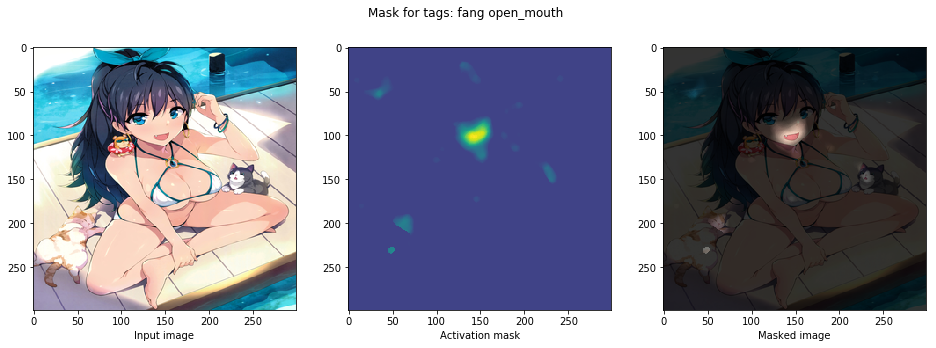

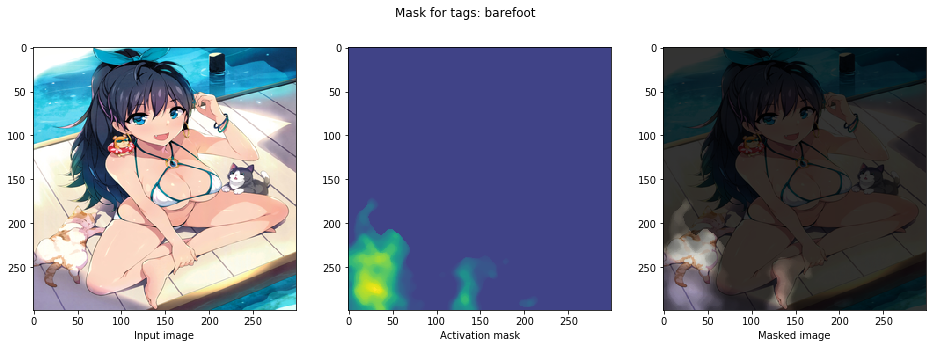

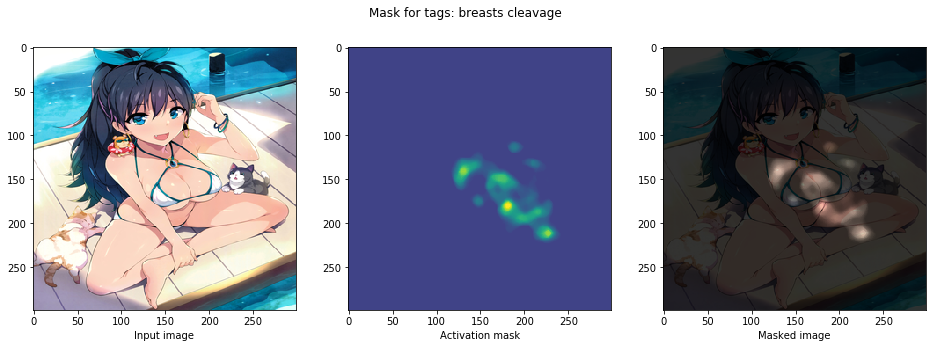

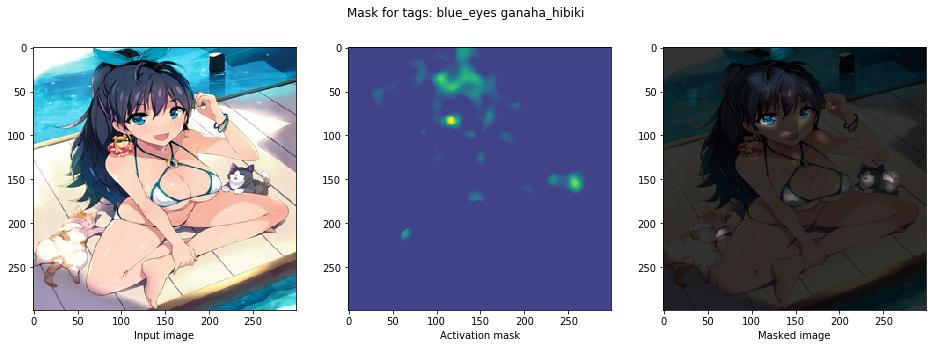

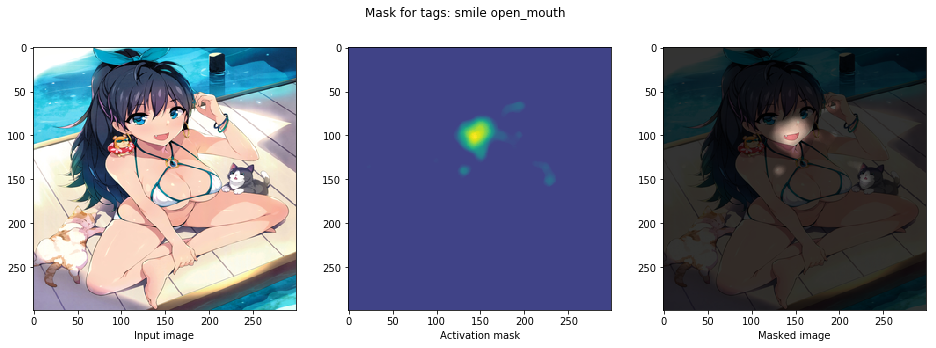

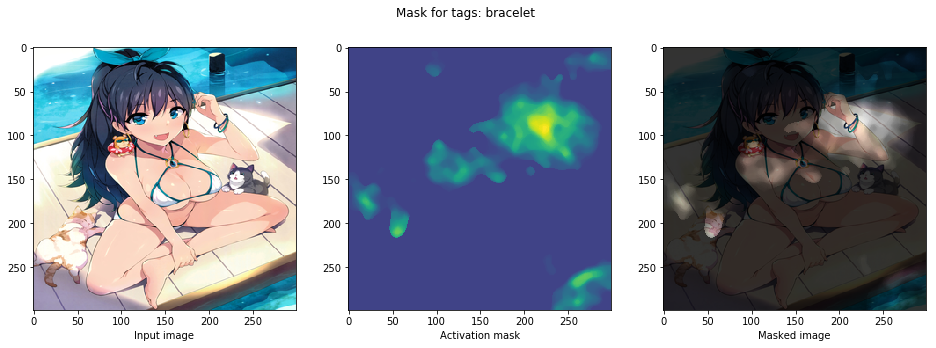

In [20]:
def plot_tags(tags):
    mask = mask_for_tags(tags, gradcam_maps_processed, 0.2)
    show_mask(image_arr[0], mask)
    plt.suptitle("Mask for tags: {}".format(" ".join(tags)))

# Show some examples
plot_tags(["fang", "open_mouth"])
plot_tags(["barefoot"])
plot_tags(["breasts", "cleavage"])
plot_tags(["blue_eyes", "ganaha_hibiki"])
plot_tags(["smile", "open_mouth"])
plot_tags(["bracelet"])